In [39]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Factor analysis and PCA libraries
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale

# Scaler
from sklearn.preprocessing import StandardScaler
import warnings

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16, 9)

In [29]:
data = pd.read_csv('store_unified_summary.csv', encoding='utf-8-sig')

### 0. 전처리

In [3]:
# 1. 제외할 컬럼 정의
exclude_cols = [
    "store_id", "owner_id",
    "open_date", "summary_year_month", "created_dttm", "updated_dttm", "last_updated_dttm"
]

# 2. 연속형 숫자형 컬럼만 선택
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 3. 제외 컬럼 제거 후 잡음 대상 컬럼만 추출
target_cols = [col for col in numeric_cols if col not in exclude_cols]

# 4. 잡음 추가 함수 정의
def add_noise(series, noise_level=0.01):
    std = series.std()
    noise = np.random.normal(0, noise_level * std, size=series.shape)
    return series + noise

# 5. 잡음 추가 적용
data_noisy = data.copy()
data_noisy[target_cols] = data_noisy[target_cols].apply(lambda col: add_noise(col, noise_level=0.01))

In [4]:
pd.set_option('display.max_columns', None)
data_noisy.head()

,store_id,owner_id,business_registration_no,industry_code,open_date,summary_year_month,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,weekday_avg_transaction_value,weekend_avg_transaction_value,cash_payment_ratio,card_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,created_dttm,updated_dttm,last_updated_dttm,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,operating_expenses,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,operating_expense_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,101,1101,101-74-60399,56112.476083,2024-11-04,2024-11,2.452750e+06,1.560467e+06,1.262032e+06,31.906688,26.891702,193.575302,89.197203,77.627058,1.180012,NaN,0.142197,16191.039256,15065.154326,18197.373263,15.599201,84.336040,40.014061,53.647572,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,871.984375,110962.476886,508.719757,9.266293,35.823574,0.004568,0.005698,6.424972,5.244705,0.006536,-0.208082,-488.580418,0.013529,3.899833,50.497247,-0.000471,-0.004777,448700.596805,1.426006e+06,409731.883283,2.677152e+06,330797.515506,254340.293416,14.274554,48.502167,15.497200,11.262598,85.713394,53.135209,44.652686,2.190476,1.215726,0.386271,1.375651e+06,60.027428,2.799698,61.849508,72.626754,59.819529,68.502178
1,101,1101,101-80-14374,56111.340272,2024-11-04,2024-12,3.620013e+06,1.916268e+06,1.528932e+06,24.686452,26.347260,169.117419,97.547886,82.741329,13.810505,NaN,0.165216,16655.161048,15827.365579,18817.066510,19.364939,80.453994,50.766327,69.792815,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,1130.606455,130865.144872,692.575463,8.558049,39.488838,-0.003261,-0.004880,8.232249,9.996489,-0.003440,0.126902,1789.834580,0.005781,3.789966,59.412214,0.003023,0.000407,377136.473932,1.527635e+06,502244.805819,2.624823e+06,330119.236897,269650.547664,12.611078,51.705660,17.194543,10.304690,87.243018,64.182552,33.193763,2.509820,0.957838,0.508249,2.339184e+06,42.438593,1.996996,77.734073,46.370603,54.888080,73.038134
2,101,1101,101-90-34754,56111.895080,2024-11-04,2025-01,3.848968e+06,1.773056e+06,1.575625e+06,20.533656,26.242140,166.690256,89.627610,92.398017,12.220110,NaN,0.149343,18796.134428,17638.621650,21003.872269,15.936256,84.266167,51.159741,63.081721,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,1083.481533,127327.790065,740.235410,8.314509,61.110037,0.003558,-0.001983,6.828187,5.985867,-0.000758,-0.359904,2933.201819,-0.006913,3.855148,57.229554,0.001368,0.004588,504316.840848,1.825350e+06,531620.061863,2.870067e+06,417641.671309,355367.860940,15.470065,48.192056,15.244805,10.998474,84.505180,63.457457,32.673484,3.997932,1.020464,0.581490,2.192929e+06,37.994381,0.983928,68.083571,62.090170,75.412976,89.147434
3,101,1101,101-04-50959,56112.098646,2024-11-04,2025-02,3.336355e+06,2.439889e+06,1.900530e+06,26.395499,33.865264,212.553063,99.268324,85.098182,13.327523,NaN,0.171292,20716.066118,19442.215261,23285.424750,18.666169,81.711064,50.006573,60.002048,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,915.241306,104841.595844,628.257419,8.183924,37.622952,0.004185,0.001941,5.654357,6.252361,-0.0014

### 1. 스케일링

In [7]:
# 1. ID 컬럼 제거
data_noisy2 = data_noisy.drop(data_noisy.columns[[0, 1]], axis=1)

# 2. 숫자형 컬럼만 선택
numeric_cols = data_noisy2.select_dtypes(include=["int64", "float64"]).columns

# 3. exclude_cols 제거
target_cols = [col for col in numeric_cols if col not in exclude_cols]

# 4. 표준화 수행
scaler = StandardScaler()
standardized_X = pd.DataFrame(
    scaler.fit_transform(data_noisy[target_cols]),
    columns=target_cols
)

# 5. 원본 데이터에 반영
data_standardized = data_noisy.copy()
data_standardized[target_cols] = standardized_X

In [8]:
data_standardized.head()

,store_id,owner_id,business_registration_no,industry_code,open_date,summary_year_month,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,weekday_avg_transaction_value,weekend_avg_transaction_value,cash_payment_ratio,card_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,created_dttm,updated_dttm,last_updated_dttm,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,operating_expenses,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,operating_expense_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,101,1101,101-74-60399,-0.496966,2024-11-04,2024-11,-0.598653,-0.598414,-0.552581,0.411557,-0.170976,-0.615580,-0.670117,-0.557430,0.217364,NaN,0.187172,-0.024798,-0.048837,-0.016581,-0.766570,0.759480,-1.392380,0.321691,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-1.199501,-1.123579,-0.385531,-1.445002,-1.445823,-0.561819,-0.449962,-0.826168,-0.945392,-0.765144,-0.483781,-0.654456,-0.443408,-0.085637,-0.709396,-0.248734,-0.286616,-0.566301,-0.577056,-0.601970,-0.574568,-0.576965,-0.595394,-0.720317,0.396190,-0.714689,0.978540,0.717152,-0.368099,0.468388,-1.334244,0.200532,-0.817391,-0.566554,-0.149869,0.215965,-0.949026,0.079959,-0.618007,-0.913209
1,101,1101,101-80-14374,-0.523475,2024-11-04,2024-12,-0.557751,-0.578492,-0.528142,-0.518907,-0.224741,-0.628027,-0.662838,-0.551331,3.445027,NaN,0.547728,0.041728,0.067338,0.062718,-0.393792,0.375123,-0.591263,1.496370,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-0.873992,-0.917202,0.101336,-1.525533,-1.200236,-0.579959,-0.477664,-0.519141,-0.123146,-0.785710,-0.474225,-0.641676,-0.452569,-0.311885,0.083105,-0.233717,-0.277927,-0.578731,-0.569502,-0.581729,-0.576853,-0.577211,-0.588367,-1.086980,1.638754,0.433827,0.134844,1.054346,1.170069,-1.112829,-0.783078,-1.239698,-0.356548,-0.531087,-1.057463,-0.154915,0.110881,-1.612753,-0.923414,-0.517827
2,101,1101,101-90-34754,-0.510526,2024-11-04,2025-01,-0.549728,-0.586511,-0.523866,-1.054074,-0.235122,-0.629262,-0.669742,-0.539814,3.038609,NaN,0.299099,0.348608,0.343406,0.342553,-0.733204,0.752562,-0.561951,1.008091,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-0.933305,-0.953882,0.227544,-1.553224,0.248469,-0.564158,-0.470077,-0.757669,-0.817142,-0.780179,-0.488112,-0.635263,-0.467578,-0.177657,-0.110924,-0.240831,-0.270918,-0.556641,-0.547375,-0.575301,-0.566142,-0.545527,-0.549025,-0.456803,0.275905,-0.885473,0.745907,0.450811,1.069111,-1.184623,1.785300,-0.889951,-0.079838,-0.536471,-1.286787,-0.622993,-0.533055,-0.599326,0.347702,0.886359
3,101,1101,101-04-50959,-0.505775,2024-11-04,2025-02,-0.567691,-0.549173,-0.494115,-0.298664,0.517676,-0.605921,-0.661338,-0.548520,3.321603,NaN,0.642897,0.623804,0.618305,0.634513,-0.462964,0.499584,-0.647870,0.784024,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-1.145057,-1.187049,-0.068984,-1.568073,-1.325258,-0.562705,-0.459800,-0.957083,-0.771028,-0.781672,-0.486024,-0.660334,-0.466603,-1.433780,-0.613715,-0.244832,-0.273505,-0.551671,-0.530544,-0.521917,-0.555225,-0.570561,-0.526235,-0.605472,0.522606,0.698869,-0.980735,0.612843,0.054339,-0.074195,0.

### 2. KMO / Bartlett 검정

In [15]:
# ===============================
# 1) 제외할 컬럼 정의 (id, 날짜, boolean)
# ===============================
exclude_cols = [
    "store_id", "owner_id",
    "open_date", "summary_year_month", "created_dttm", "updated_dttm", "last_updated_dttm"
]

# ===============================
# 2) 숫자형 컬럼만 선택 후 exclude_cols 제거
# ===============================
numeric_cols = data_standardized.select_dtypes(include=["int64", "float64"]).columns
validation_cols = [col for col in numeric_cols if col not in exclude_cols]
X_validation = data_standardized[validation_cols]

# ===============================
# 3) NaN / Inf 제거
# ===============================
X_validation = X_validation.replace([np.inf, -np.inf], np.nan).dropna()

# ===============================
# 4) 분산이 0에 가까운 컬럼 제거
# ===============================
selector = VarianceThreshold(threshold=1e-5)
X_validation_filtered = pd.DataFrame(
    selector.fit_transform(X_validation),
    columns=X_validation.columns[selector.get_support()]
)

# ===============================
# 5) 상관 높은 컬럼 제거 (선택적으로)
# ===============================
corr_matrix = X_validation_filtered.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.999)]
X_validation_filtered = X_validation_filtered.drop(columns=to_drop)
print("Data shape after preprocessing:", X_validation_filtered.shape)

# ===============================
# 6) Bartlett's Test
# ===============================
chi_square_value, p_value = calculate_bartlett_sphericity(X_validation_filtered)
print("Bartlett’s test: Chi-square =", chi_square_value, " p-value =", p_value)

# ===============================
# 7) KMO Test
# ===============================
kmo_all, kmo_model = calculate_kmo(X_validation_filtered)
print("KMO Model:", kmo_model)

Data shape after preprocessing: (392, 54)
Bartlett’s test: Chi-square = 43813.435880580946  p-value = 0.0
KMO Model: 0.8531126739136554


In [12]:
X_validation_filtered.head()

,industry_code,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,cash_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,-0.470179,-0.382363,-0.404176,-0.287148,0.530288,0.682547,-0.536222,-0.588481,-0.452471,1.128134,1.206569,-0.150052,1.190269,0.303832,-0.052653,0.772412,0.306475,0.499517,1.300990,0.093839,-0.530355,-0.582168,2.160150,0.155249,0.007801,-0.783124,-0.479044,-0.631627,-0.468228,-0.682118,0.276926,-0.266697,1.387909,-0.393171,-0.372896,-0.323201,-0.413521,-0.296666,-0.447930,0.124980,1.129869,-0.850573,0.315885,-0.308758,-0.013274,-0.323343,0.669038,-0.399151,-1.277177,2.586278,-0.000979,-0.415754,-0.400013,-1.128754
1,-0.466588,-0.349161,-0.379813,-0.263776,-0.509403,0.824048,-0.512546,-0.548963,-0.439404,0.971030,1.205979,-0.151167,1.138874,0.584374,-0.319722,0.926298,0.147155,0.055407,1.403432,-0.702484,0.576639,-0.581702,-0.472344,-0.032711,0.104558,-0.772849,-0.475260,-0.658843,-0.452664,0.219905,0.368624,-0.257960,-0.275816,-0.387203,-0.326077,-0.393374,-0.316289,-0.266172,-0.584701,0.727962,-1.221511,0.574826,-0.502511,0.628202,-1.633053,0.385772,2.712126,-0.398621,-0.924631,-1.084341,0.661126,-0.819262,-1.658186,-1.285438
2,-0.477949,-0.346242,-0.388813,-0.250199,-0.719265,0.204508,-0.483274,-0.521141,-0.419460,1.146258,1.192503,0.227026,0.900460,-0.104414,-0.853141,1.390472,-0.707113,-0.695258,0.194432,-0.118940,-0.960291,-0.575421,2.147120,-0.314712,0.052652,-0.779065,-0.476960,-0.656230,-0.457215,0.156238,-0.156905,-0.256599,-0.299574,-0.341587,-0.311580,-0.389228,-0.298960,-0.288296,-0.062674,0.633880,-2.155740,0.605546,0.952021,-0.972663,0.095156,-0.956135,1.584668,-0.426066,-1.129776,-0.897297,-0.737450,-1.352740,0.120049,-1.117532
3,-0.492765,-0.312800,-0.356905,-0.237548,-0.528402,-0.003983,-0.483120,-0.533583,-0.402716,0.977730,1.197269,0.164539,1.126832,0.502116,-0.525092,0.256251,-0.685582,-0.707698,-0.654287,0.054694,-1.804219,-0.562770,-0.469053,-0.070059,0.074994,-0.772824,-0.471732,-0.647336,-0.457820,0.419389,0.241817,-0.250420,-0.283627,-0.340580,-0.300620,-0.314512,-0.331826,-0.281287,-0.068245,0.097213,0.323611,-0.675954,-0.226268,0.296065,-1.034345,0.117515,0.368222,-0.374544,-1.490763,-0.651769,-1.459042,0.014061,0.498663,-0.077132
4,-0.498154,-0.321483,-0.351865,-0.216460,-0.836719,-0.327278,-0.514018,-0.542264,-0.431081,1.353991,1.199457,0.628669,1.632442,-0.449733,-1.262355,0.905662,-0.931511,-0.861215,-0.657037,-0.258351,-0.887706,1.736763,-0.463349,0.141846,-0.157825,1.281424,-0.261341,1.025645,-0.469921,0.430014,0.838327,-0.240291,1.384368,-0.223376,-0.281694,-0.347099,-0.423946,-0.293991,0.852960,0.492984,-1.287881,-2.737326,-1.208190,1.101308,1.244996,1.284165,1.078021,-0.365399,-1.514939,0.799948,0.655423,-1.474031,0.727008,-0.260507


### 3. 요인분석

Eigenvalues: [1.85549596e+01 8.63425429e+00 5.71090095e+00 2.74963114e+00
 2.40794102e+00 1.60831160e+00 1.30624568e+00 1.23629036e+00
 1.05986155e+00 1.03989619e+00 1.00299955e+00 9.50444647e-01
 9.34829522e-01 8.38214807e-01 8.03010531e-01 7.86836925e-01
 7.75382333e-01 7.24749576e-01 6.96096922e-01 6.81738187e-01
 6.66158994e-01 6.47264759e-01 5.99965442e-01 5.55407107e-01
 5.24694089e-01 5.04672830e-01 4.38917928e-01 3.75112210e-01
 3.38494125e-01 3.00773995e-01 2.48398242e-01 2.01934199e-01
 1.78262048e-01 1.64438765e-01 1.56354370e-01 1.55359336e-01
 1.17529179e-01 1.07133844e-01 5.55348436e-02 3.96731950e-02
 3.52780641e-02 2.70712714e-02 2.00279360e-02 1.32160633e-02
 7.15778915e-03 7.00489877e-03 6.18395506e-03 3.23498177e-03
 1.01798937e-03 2.51430779e-04 1.11885437e-04 1.05952016e-04
 1.04463211e-04 9.77386773e-05 9.66966235e-05 9.57863180e-05
 9.25876563e-05 8.80588798e-05 8.75988032e-05]


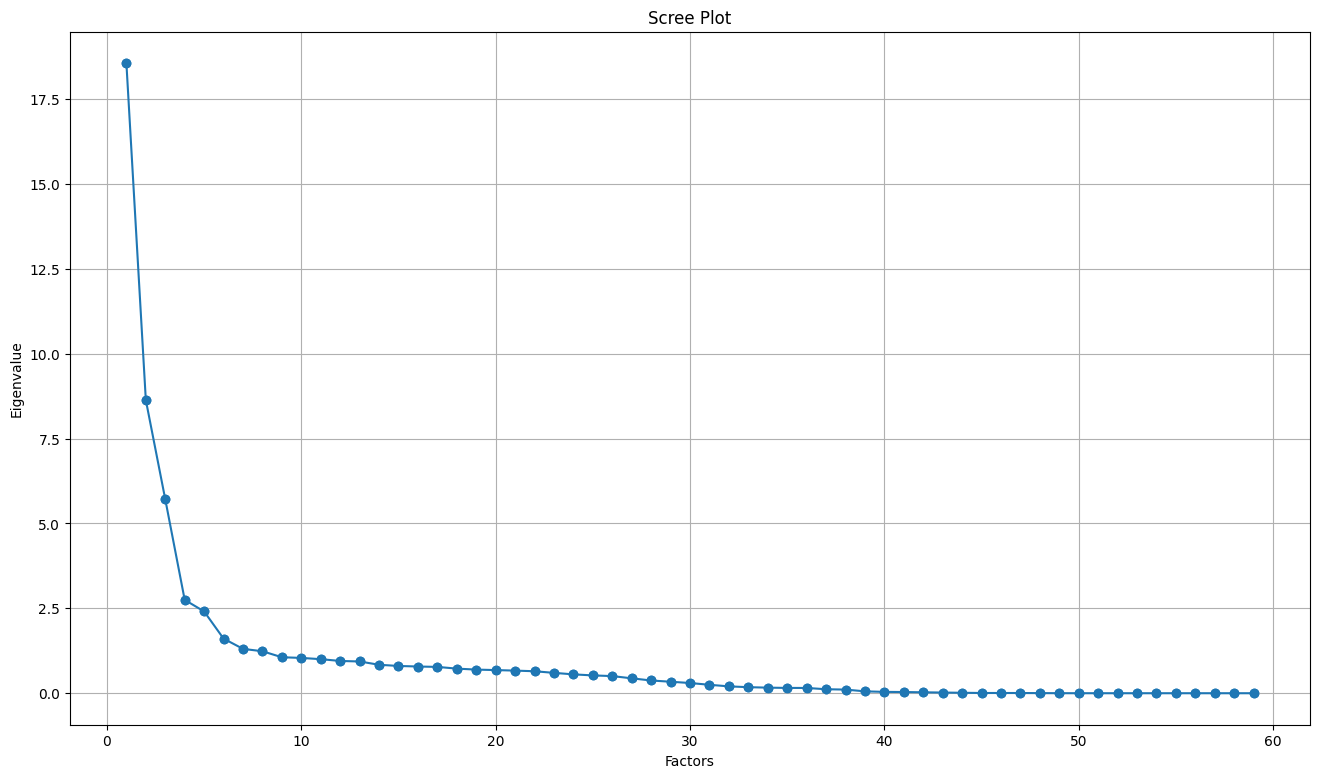

In [17]:
# 최대 요인 개수 = 변수 개수
fa = FactorAnalyzer(n_factors=standardized_X.shape[1], rotation=None)
fa.fit(standardized_X)

# 고유값 확인
ev, v = fa.get_eigenvalues()
print("Eigenvalues:", ev)

# Scree plot
plt.scatter(range(1, standardized_X.shape[1]+1), ev)
plt.plot(range(1, standardized_X.shape[1]+1), ev, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [19]:
# 요인분석 수행 (예: n_factors=5)
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(X_validation_filtered)

# 요인적재량
loadings = pd.DataFrame(fa.loadings_, index=X_validation_filtered.columns)

# 공통성
communalities = pd.DataFrame(fa.get_communalities(), index=X_validation_filtered.columns, columns=["Communality"])

In [24]:
# 각 행에서 절댓값이 최대인 값을 찾아 배경색을 노란색으로 지정하는 함수
def highlight_max_loading(row):
    is_max = row.abs() == row.abs().max()
    return ['background-color: #FFFACD' if v else '' for v in is_max]
    

# 요인 적재량 확인
result = loadings.style.apply(highlight_max_loading, axis=1)
result

,0,1,2,3,4
industry_code,0.116556,0.006020,-0.966444,0.066420,0.046847
total_sales_amount,0.973512,0.170521,0.048780,0.118920,0.057921
weekday_sales_amount,0.962219,0.174757,0.103079,0.088949,0.095055
weekend_sales_amount,0.968811,0.159898,-0.041820,0.166997,-0.002343
lunch_sales_ratio,-0.137096,-0.164957,0.761257,-0.254407,0.038416
dinner_sales_ratio,-0.052996,0.277034,0.849174,-0.057649,-0.008179
transaction_count,0.886129,0.123080,-0.291956,0.235203,0.001783
weekday_transaction_count,0.914119,0.130586,-0.232792,0.209882,0.046337
weekend_transaction_count,0.825525,0.109976,-0.364450,0.262760,-0.057744
mom_growth_rate,0.428615,0.508440,-0.093638,0.495287,-0.206454


In [27]:
# communalities 확인
def highlight_low_comm(row):
    is_under = row.abs() < 0.5
    return ['background-color: #FFFACD' if v else '' for v in is_under]

result2 = communalities.style.apply(highlight_low_comm, axis=1)
result2

,Communality
industry_code,0.954242
total_sales_amount,0.996679
weekday_sales_amount,0.983978
weekend_sales_amount,0.993803
lunch_sales_ratio,0.691717
dinner_sales_ratio,0.804043
transaction_count,0.940935
weekday_transaction_count,0.953056
weekend_transaction_count,0.898788
mom_growth_rate,0.738922


In [30]:
# 각 요인의 설명 분산 확인
ev, v, cv = fa.get_factor_variance()
ev_df = pd.DataFrame(
    {'SS Loadings': ev, 'Proportional Var': v, 'Cumulative Var': cv},
    index=[f'Factor{i+1}' for i in range(fa.n_factors)]
)

In [31]:
ev_df

,SS Loadings,Proportional Var,Cumulative Var
Factor1,12.029197,0.222763,0.222763
Factor2,9.780308,0.181117,0.403880
Factor3,4.565517,0.084547,0.488426
Factor4,4.336463,0.080305,0.568731
Factor5,2.482210,0.045967,0.614698


In [28]:
# ==============================
# 현재 사용 중인 데이터를 CSV로 내보내기
# ==============================

X_validation_filtered.to_csv('FA_input_data_20250909.csv', index=False, encoding='utf-8-sig')

### 5. PCA 시각화

Explained variance ratio: [3.77425416e-01 1.34818853e-01 7.89236943e-02 5.32947593e-02
 4.03446003e-02 2.74579387e-02 1.93636271e-02 1.89696423e-02
 1.78081864e-02 1.61766275e-02 1.57521507e-02 1.44953982e-02
 1.40343461e-02 1.31309253e-02 1.26426600e-02 1.19360173e-02
 1.14405694e-02 1.10413640e-02 1.05848159e-02 9.89272717e-03
 9.46325247e-03 9.03503349e-03 8.59677400e-03 7.88721948e-03
 7.87990223e-03 7.31803457e-03 6.28119660e-03 5.08574166e-03
 4.44132071e-03 3.33773066e-03 3.18870684e-03 3.02108923e-03
 2.57636648e-03 2.28029532e-03 2.06652018e-03 1.74191445e-03
 1.51015259e-03 1.29587335e-03 8.16299537e-04 6.55715776e-04
 5.95864760e-04 3.82448100e-04 2.91546584e-04 2.23656530e-04
 1.57467461e-04 1.48335312e-04 1.04166398e-04 5.29740356e-05
 2.02818624e-05 3.86456007e-06 1.62990878e-06 1.55157915e-06
 1.41542621e-06 1.33846446e-06]
Components (Loadings):
     industry_code  total_sales_amount  weekday_sales_amount  \
0        0.032613            0.253550              0.249567   

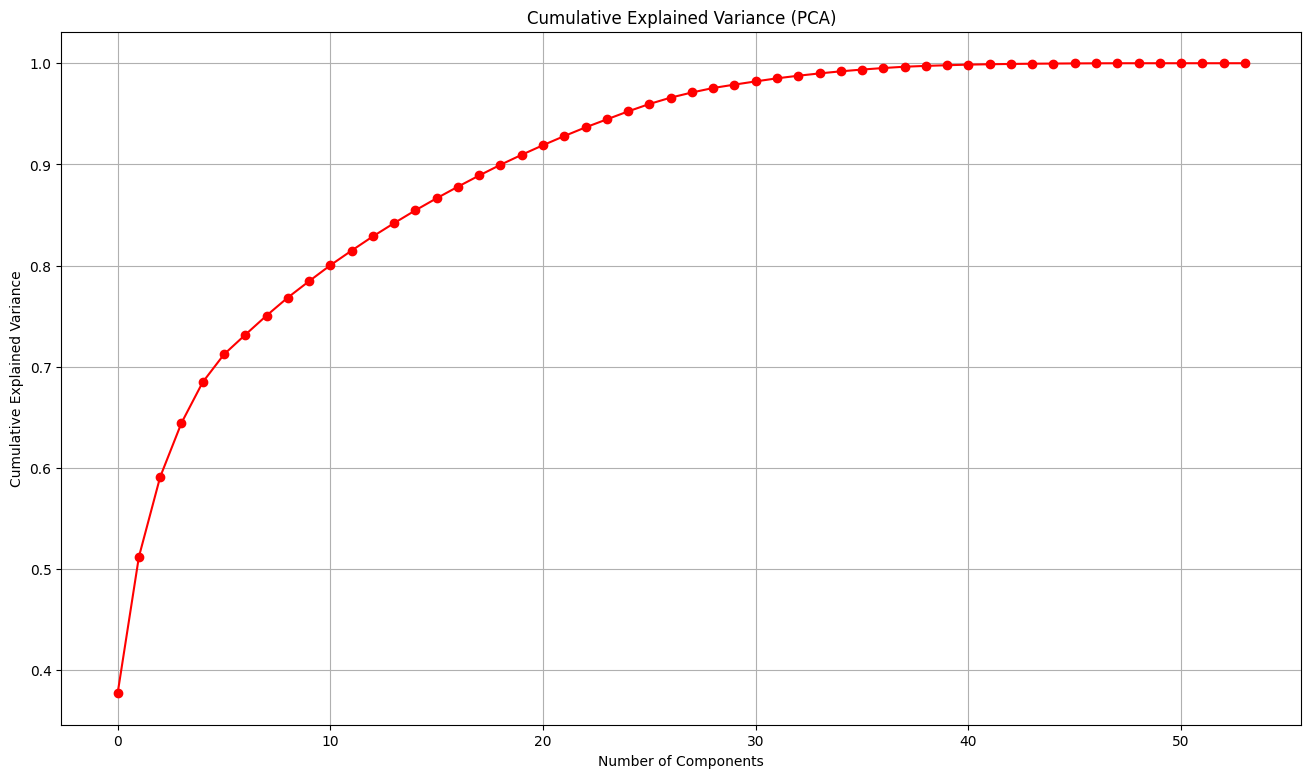

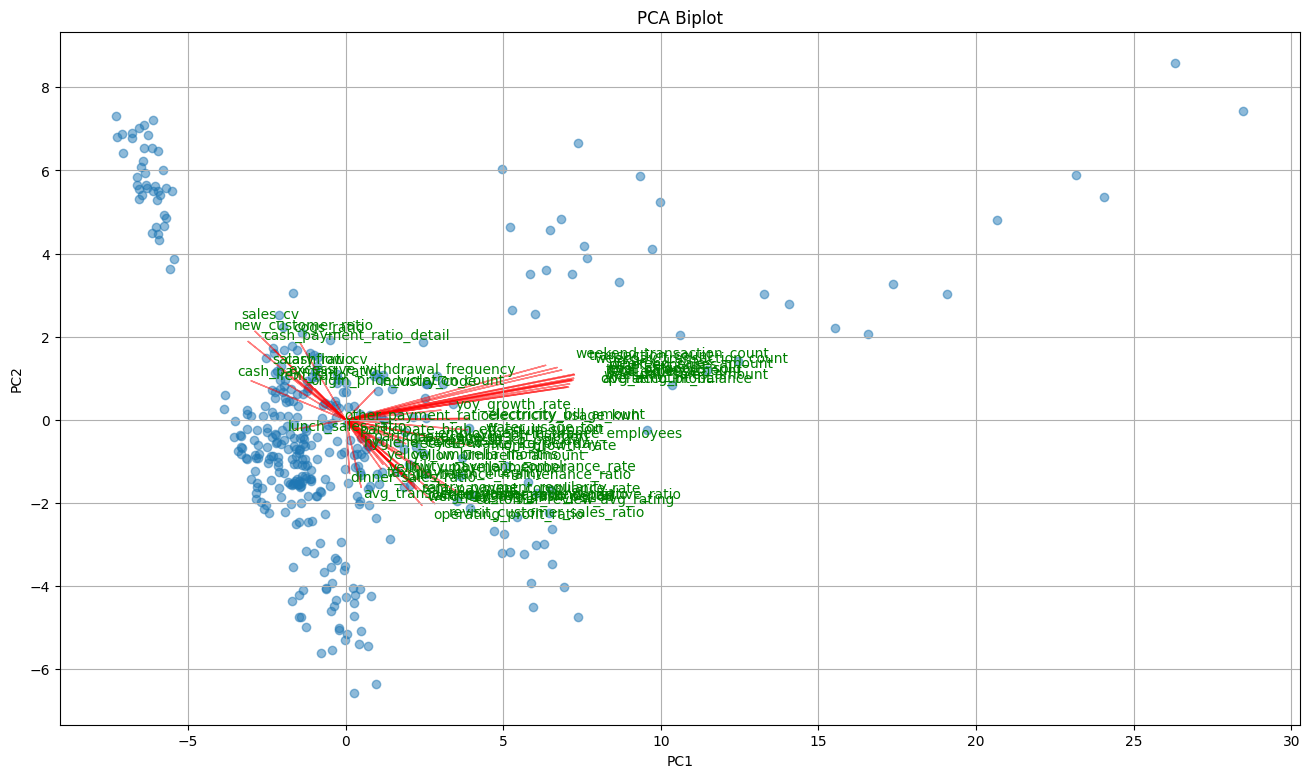

In [35]:
# pca_X = standardized_X.copy() # 원본 코드
pca_X = X_validation_filtered.copy() # 수정된 코드

# PCA 모델 생성 및 학습
pca = PCA()
pca.fit(pca_X)

# 주성분 결과 출력
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Components (Loadings):\n", pd.DataFrame(pca.components_, columns=pca_X.columns))

# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='red')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Biplot 함수 (함수 정의는 수정할 필요 없음)
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    plt.scatter(xs, ys, alpha=0.5)
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i,0]*max(xs), coeff[i,1]*max(ys),
                  color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]*max(xs)*1.15, coeff[i,1]*max(ys)*1.15, "Var"+str(i+1), color='g')
        else:
            plt.text(coeff[i,0]*max(xs)*1.15, coeff[i,1]*max(ys)*1.15, labels[i], color='g')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Biplot")
    plt.grid(True)
    plt.show()

# Biplot 호출 시에도 수정된 pca_X와 해당 열 이름을 사용
biplot(pca.transform(pca_X), pca.components_.T, labels=pca_X.columns)

### 6. 점수 계산

## 최종 점수 산출 과정 ##
 - Factor1: 소속 변수 12개, 가중치(설명분산)=0.2228 적용 완료
 - Factor2: 소속 변수 25개, 가중치(설명분산)=0.1811 적용 완료
 - Factor3: 소속 변수 6개, 가중치(설명분산)=0.0845 적용 완료
 - Factor4: 소속 변수 5개, 가중치(설명분산)=0.0803 적용 완료
 - Factor5: 소속 변수 6개, 가중치(설명분산)=0.0460 적용 완료

## 최종 산출 점수 (상위 5개) ##
   final_score  Factor1_Score  Factor2_Score  Factor3_Score  Factor4_Score  \
0    -1.718572      -4.540871      -5.583837       2.285299       2.078959   
1    -1.226720      -4.287688      -2.253176       1.510843       1.055157   
2    -2.083489      -4.182123      -6.072209       0.454299      -0.429144   
3    -1.354322      -3.995689      -2.183453       0.764705      -0.746598   
4    -0.544645      -4.032297       1.919015       0.565003      -1.299464   

   Factor5_Score  
0      -1.215495  
1      -1.652607  
2      -1.219032  
3      -1.598290  
4       1.362286  


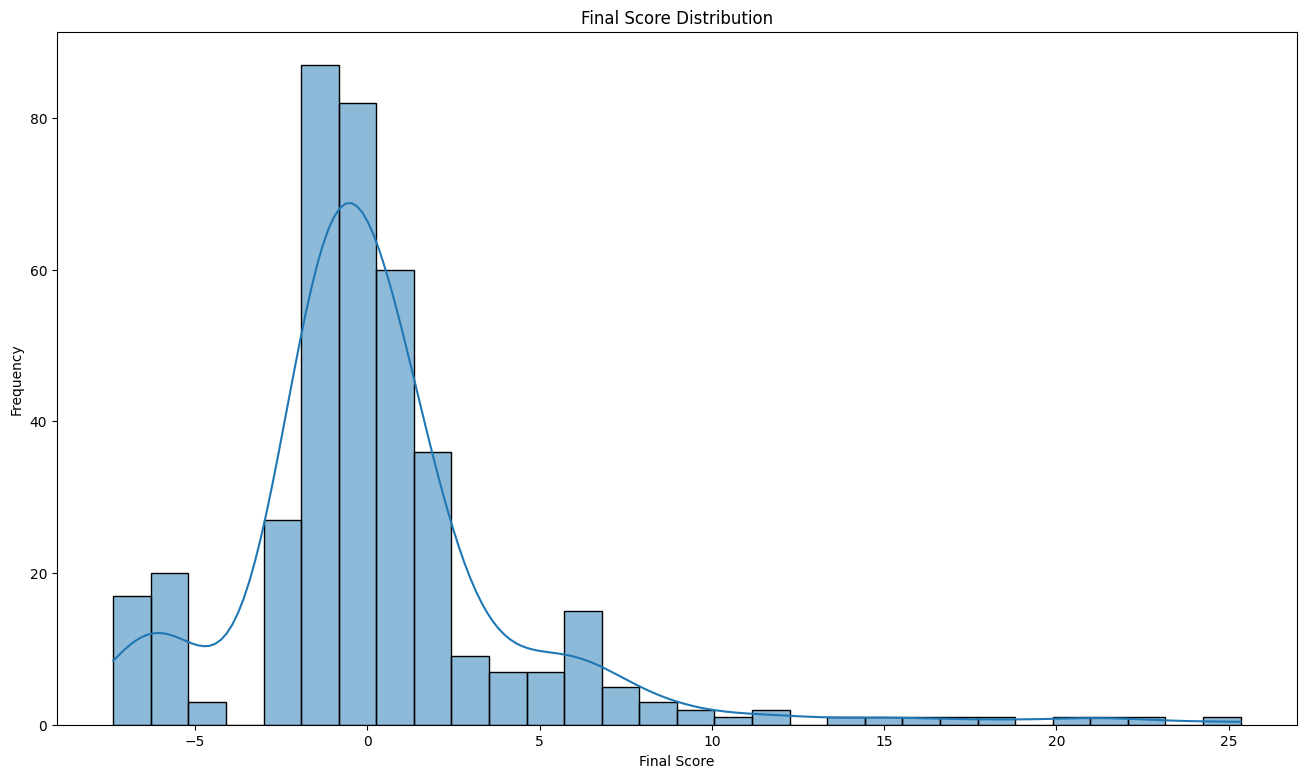

In [36]:
# 1. Proportional Var를 가중치로 사용
factor_weights = v

# 2. 변수별 소속 요인 결정: 가장 높은 적재량 값을 갖는 요인에 할당
# 결과 예시: {'매출액': 0, '고객수': 0, '전기요금': 1, ...}
variable_factor_mapping = loadings.abs().idxmax(axis=1)

# 3. 요인별 점수 및 최종 가중합 계산을 위한 데이터프레임 준비
# 원본 데이터의 인덱스를 그대로 사용
final_scores_df = pd.DataFrame(index=X_validation_filtered.index)
final_scores_df['final_score'] = 0  # 최종 점수를 저장할 컬럼 초기화

print("## 최종 점수 산출 과정 ##")
# 각 요인(Factor)별로 루프를 실행
for i in range(fa.n_factors):
    factor_name = f'Factor{i+1}'
    
    # 현재 요인(i)에 속하는 변수들만 선택
    variables_in_factor = variable_factor_mapping[variable_factor_mapping == i].index
    
    # 요인별 점수를 계산할 컬럼 초기화 (0으로 채워진 Series)
    factor_score_col = pd.Series(0, index=X_validation_filtered.index)
    
    # 해당 요인에 속한 변수들로 요인 점수 계산
    for var in variables_in_factor:
        # (변수의 표준화된 값 * 해당 변수의 요인 적재량)을 더해나감
        factor_score_col += X_validation_filtered[var] * loadings.loc[var, i]
    
    # 계산된 요인별 점수를 결과 데이터프레임에 추가
    final_scores_df[f'{factor_name}_Score'] = factor_score_col
    
    # 최종 점수에 (요인별 점수 * 요인별 가중치)를 더함
    final_scores_df['final_score'] += factor_score_col * factor_weights[i]
    print(f" - {factor_name}: 소속 변수 {len(variables_in_factor)}개, 가중치(설명분산)={factor_weights[i]:.4f} 적용 완료")

# 4. 결과 확인 (상위 5개 행)
print("\n## 최종 산출 점수 (상위 5개) ##")
print(final_scores_df.head())


# 5. 최종 점수 분포 시각화
sns.histplot(final_scores_df['final_score'], kde=True, bins=30)
plt.title('Final Score Distribution')
plt.xlabel('Final Score')
plt.ylabel('Frequency')
plt.show()

## 표준편차 기반 신용 점수 (Higher is Better) ##
   final_score  credit_score_std
0    -1.718572               202
1    -1.226720               221
2    -2.083489               188
3    -1.354322               216
4    -0.544645               248


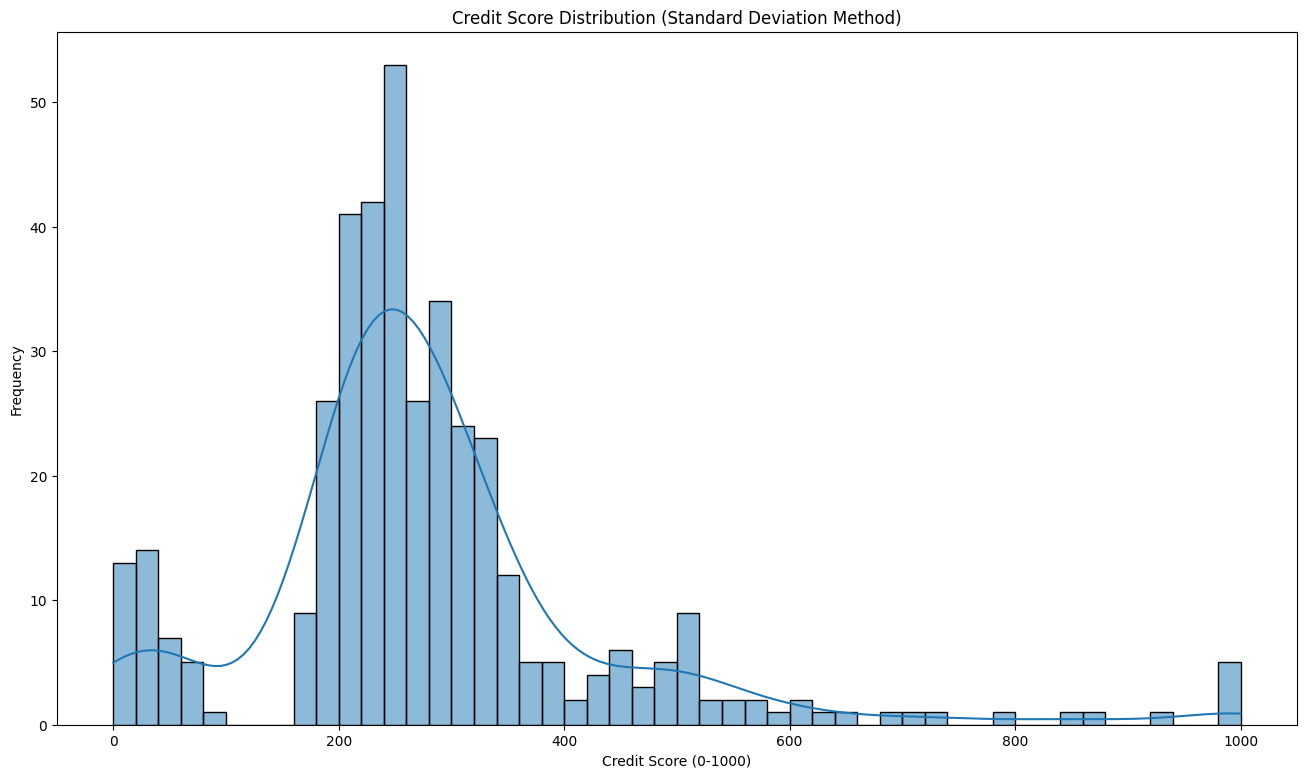

In [41]:
# 1. 이상치 영향을 줄이기 위해 하위 1%와 상위 99% 값을 경계로 설정
lower_bound = final_scores_df['final_score'].quantile(0.01)
upper_bound = final_scores_df['final_score'].quantile(0.99)

# 2. 경계를 벗어나는 값들을 경계값으로 고정 (Clipping)
clipped_score = final_scores_df['final_score'].clip(lower_bound, upper_bound)

# 3. 정리된 점수 범위를 0~1 사이로 스케일링 후 1000을 곱함
# 'Higher is Better' 로직이므로 이대로 사용합니다.
final_scores_df['credit_score_std'] = minmax_scale(clipped_score) * 1000

# 4. 최종 점수를 정수형으로 변환
final_scores_df['credit_score_std'] = final_scores_df['credit_score_std'].astype(int)

# 5. 결과 확인
print("## 표준편차 기반 신용 점수 (Higher is Better) ##")
print(final_scores_df[['final_score', 'credit_score_std']].head())

# 6. 변환된 점수 분포 시각화
sns.histplot(final_scores_df['credit_score_std'], bins=50, kde=True)
plt.title("Credit Score Distribution (Standard Deviation Method)")
plt.xlabel("Credit Score (0-1000)")
plt.ylabel("Frequency")
plt.show()

### 7. 신규 데이터에 대한 점수 산출

In [47]:
import joblib

# 저장할 모든 자산을 하나의 딕셔너리에 담기
artifacts = {
    # [중요] Scaler는 필터링 전의 넓은 범위의 변수들을 학습했음
    "scaler_columns": validation_cols,  # Scaler가 학습한 컬럼 목록
    "scaler": scaler,                  # 학습된 Scaler 객체
    
    # 필터링 객체들
    "selector": selector,              # 학습된 VarianceThreshold 객체
    "to_drop_corr": to_drop,           # 제거할 상관관계 높은 변수 목록
    
    # [중요] FactorAnalyzer는 모든 필터링이 끝난 후의 변수들을 학습했음
    "fa_columns": X_validation_filtered.columns, # FactorAnalyzer가 학습한 최종 컬럼 목록
    "factor_analyzer": fa,                       # 학습된 FactorAnalyzer 객체
    
    # 점수 계산에 필요한 나머지 자산들
    "loadings": loadings,
    "variable_factor_mapping": variable_factor_mapping,
    "factor_weights": factor_weights,
    "score_lower_bound": lower_bound,
    "score_upper_bound": upper_bound,
}

# 파일로 저장
joblib.dump(artifacts, 'credit_scoring_artifacts.pkl')

['credit_scoring_artifacts.pkl']

페르소나 정의 (Gemini가 만들어줬는데 제무요소만 고려해서 만든거 같음)

- 초우량 안정성장형 (김사장님, 15년차 한식당): 오랜 경험과 노하우로 안정적인 매출과 높은 이익률을 유지합니다. 재방문 고객이 많고, 모든 납부를 제때 처리하며 재무적으로 매우 건전합니다.

- 고위험 매출감소형 (박사장님, 10년차 중식당): 상권이 쇠퇴하며 수년째 매출이 감소하고 있습니다. 높은 비용 구조로 영업이익이 적자이며, 현금흐름이 불안정해 공과금 등을 가끔 연체합니다.

- 고성장 신규창업형 (이사장님, 1년차 트렌디 카페): SNS에서 인기를 끌며 매출이 폭발적으로 성장 중인 신규 창업가입니다. 잠재력은 높지만, 재투자 비용이 많아 이익은 적고 아직 재무 안정성은 낮습니다.

- 현상유지 일반형 (최사장님, 4년차 양식당): 동네에서 꾸준히 운영 중인 일반적인 사업체입니다. 매출이나 이익이 크게 늘지도 줄지도 않으며, 재무적으로 큰 문제는 없지만 눈에 띄는 장점도 없는 현상유지 상태입니다.

In [52]:
# 테스트 데이터
data = {
    'store_id': [116, 111, 101, 126], 'owner_id': [1116, 1111, 1101, 1126], 'business_registration_no': ['116-XX-XXXXX', '111-XX-XXXXX', '101-XX-XXXXX', '126-XX-XXXXX'], 'industry_code': ['56111', '56114', '56220', '56113'], 'open_date': ['2015-03-10', '2010-05-20', '2024-09-01', '2021-07-18'], 'summary_year_month': ['2025-08', '2025-08', '2025-08', '2025-08'], 'total_sales_amount': [38000000.0, 11000000.0, 15000000.0, 21000000.0], 'weekday_sales_amount': [24700000.0, 8250000.0, 8250000.0, 14700000.0], 'weekend_sales_amount': [13300000.0, 2750000.0, 6750000.0, 6300000.0], 'lunch_sales_ratio': [35.0, 42.0, 15.0, 28.0], 'dinner_sales_ratio': [45.0, 30.0, 25.0, 40.0], 'transaction_count': [1520, 733, 2142, 1050], 'weekday_transaction_count': [988, 550, 1178, 735], 'weekend_transaction_count': [532, 183, 964, 315], 'mom_growth_rate': [0.5, -8.5, 12.5, -1.5], 'yoy_growth_rate': [4.5, -25.0, 150.0, -5.0], 'sales_cv': [0.045, 0.32, 0.18, 0.11], 'avg_transaction_value': [25000.0, 15000.0, 7000.0, 20000.0], 'revisit_customer_sales_ratio': [75.0, 25.0, 30.0, 55.0], 'new_customer_ratio': [15.0, 65.0, 70.0, 40.0], 'electricity_usage_kwh': [2200.0, 1200.0, 1800.0, 1900.0], 'electricity_bill_amount': [250000.0, 150000.0, 210000.0, 220000.0], 'gas_usage_m3': [760.0, 460.0, 180.0, 670.0], 'water_usage_ton': [35.0, 18.0, 22.0, 28.0], 'energy_eff_appliance_ratio': [85.0, 30.0, 65.0, 55.0], 'participate_energy_eff_support': [1, 0, 0, 0], 'food_waste_kg_per_day': [15.0, 12.0, 4.0, 10.0], 'recycle_waste_kg_per_day': [12.0, 8.0, 8.0, 9.0], 'yellow_umbrella_member': [1, 0, 0, 1], 'yellow_umbrella_months': [120, 0, 0, 36], 'yellow_umbrella_amount': [500000.0, 0.0, 0.0, 200000.0], 'employment_insurance_employees': [4, 1, 2, 3], 'customer_review_avg_rating': [4.6, 3.2, 4.1, 3.9], 'customer_review_positive_ratio': [92.0, 65.0, 82.0, 78.0], 'hygiene_certified': [1, 0, 0, 0], 'origin_price_violation_count': [0, 2, 0, 0], 'operating_profit': [9500000.0, -1100000.0, 1500000.0, 3150000.0], 'cost_of_goods_sold': [15200000.0, 5720000.0, 7500000.0, 9450000.0], 'total_salary': [6840000.0, 2640000.0, 2250000.0, 3780000.0], 'rent_expense': [3420000.0, 1760000.0, 1800000.0, 2100000.0], 'other_expenses': [3040000.0, 1980000.0, 1950000.0, 2520000.0], 'operating_profit_ratio': [25.0, -10.0, 10.0, 15.0], 'cogs_ratio': [40.0, 52.0, 50.0, 45.0], 'salary_ratio': [18.0, 24.0, 15.0, 18.0], 'rent_ratio': [9.0, 16.0, 12.0, 10.0], 'cashflow_cv': [0.15, 1.85, 0.95, 0.55], 'avg_account_balance': [35000000.0, 2200000.0, 6000000.0, 15000000.0], 'min_balance_maintenance_ratio': [90.0, 25.0, 40.0, 65.0], 'excessive_withdrawal_frequency': [0.5, 8.0, 4.0, 2.0], 'rent_payment_compliance_rate': [100.0, 75.0, 95.0, 98.0], 'utility_payment_compliance_rate': [100.0, 80.0, 90.0, 95.0], 'salary_payment_regularity': [100.0, 85.0, 98.0, 99.0], 'tax_payment_integrity': [100.0, 70.0, 90.0, 95.0], 'cash_payment_ratio': [15.0, 45.0, 25.0, 30.0], 'card_payment_ratio': [85.0, 55.0, 75.0, 70.0], 'participate_high_eff_equip_support': [1, 0, 0, 0], 'cash_payment_ratio_detail': [14.0, 42.0, 23.0, 28.0], 'card_payment_ratio_detail': [83.0, 54.0, 74.0, 69.0], 'other_payment_ratio': [3.0, 4.0, 3.0, 3.0], 'weighted_avg_cash_period': [2.1, 1.5, 2.0, 1.8], 'operating_expenses': [28500000.0, 12100000.0, 13500000.0, 17850000.0], 'operating_expense_ratio': [75.0, 110.0, 90.0, 85.0], 'weekday_avg_transaction_value': [24000.0, 14000.0, 6500.0, 19000.0], 'weekend_avg_transaction_value': [26000.0, 16000.0, 7500.0, 21000.0]
}
new_data_df = pd.DataFrame(data)

In [53]:
def get_credit_score(new_data_df):
    """
    신규 데이터(DataFrame)를 입력받아 최종 신용 점수를 계산하는 파이프라인 함수.
    
    [필수 조건]
    1. 이 함수와 같은 경로에 'credit_scoring_artifacts.pkl' 파일이 있어야 합니다.
    2. new_data_df는 학습에 사용된 초기 데이터와 동일한 컬럼명을 가지고 있어야 합니다.
    
    :param new_data_df: 신규 상점 데이터 (1개 또는 여러 개)
    :return: 최종 점수가 포함된 DataFrame
    """
    try:
        # 1. 저장된 모델 자산(artifacts) 불러오기
        artifacts = joblib.load('credit_scoring_artifacts.pkl')
    except FileNotFoundError:
        print("에러: 'credit_scoring_artifacts.pkl' 파일을 찾을 수 없습니다.")
        print("학습 코드를 먼저 실행하여 모델 자산 파일을 생성해야 합니다.")
        return None

    # --- 2. 전처리 단계 ---
    # 저장된 객체 및 컬럼 목록 추출
    scaler = artifacts['scaler']
    scaler_cols = artifacts['scaler_columns']
    selector = artifacts.get('selector') # selector가 없을 수도 있으므로 .get() 사용
    to_drop_corr = artifacts['to_drop_corr']
    fa_cols = artifacts['fa_columns']

    # 2-1. Scaler가 학습했던 컬럼들만 신규 데이터에서 선택
    # 만약 신규 데이터에 컬럼이 부족하면 0으로 채움
    processed_df = pd.DataFrame(columns=scaler_cols, index=new_data_df.index)
    common_cols = [col for col in scaler_cols if col in new_data_df.columns]
    processed_df[common_cols] = new_data_df[common_cols]
    processed_df.fillna(0, inplace=True)

    # 2-2. 저장된 Scaler로 표준화 수행 (.transform)
    scaled_data = scaler.transform(processed_df)
    scaled_df = pd.DataFrame(scaled_data, columns=scaler_cols, index=processed_df.index)

    # 2-3. 저장된 VarianceThreshold로 변수 제거 (.transform)
    if selector:
        var_filtered_data = selector.transform(scaled_df)
        filtered_df = pd.DataFrame(var_filtered_data, 
                                   columns=scaled_df.columns[selector.get_support()],
                                   index=scaled_df.index)
    else:
        filtered_df = scaled_df

    # 2-4. 저장된 상관관계 변수 목록으로 변수 제거 (.drop)
    filtered_df = filtered_df.drop(columns=to_drop_corr, errors='ignore')

    # 2-5. 최종적으로 FactorAnalyzer가 학습했던 변수/순서와 동일하게 맞춤
    final_processed_data = filtered_df[fa_cols]
    
    # --- 3. 최종 점수 계산 단계 ---
    final_scores_df = pd.DataFrame(index=final_processed_data.index)
    final_scores_df['final_score'] = 0
    
    fa_model = artifacts['factor_analyzer']
    loadings = artifacts['loadings']
    mapping = artifacts['variable_factor_mapping']
    weights = artifacts['factor_weights']

    for i in range(fa_model.n_factors):
        variables_in_factor = mapping[mapping == i].index
        factor_score_col = pd.Series(0.0, index=final_processed_data.index)
        
        for var in variables_in_factor:
            if var in final_processed_data.columns:
                factor_score_col += final_processed_data[var] * loadings.loc[var, i]
        final_scores_df['final_score'] += factor_score_col * weights[i]
        
    # --- 4. 0-1000점 척도 변환 단계 ---
    lower_b, upper_b = artifacts['score_lower_bound'], artifacts['score_upper_bound']
    clipped_score = final_scores_df['final_score'].clip(lower_b, upper_b)
    final_scores_df['credit_score'] = ((clipped_score - lower_b) / (upper_b - lower_b)) * 1000
    final_scores_df['credit_score'] = final_scores_df['credit_score'].fillna(0).astype(int)
    
    # 원본 데이터와 최종 점수 합쳐서 반환
    return pd.concat([new_data_df, final_scores_df], axis=1)

In [54]:
final_results = get_credit_score(new_data_df)

# 결과 요약
summary_display = final_results[[
    'store_id', 'total_sales_amount', 'mom_growth_rate', 
    'operating_profit_ratio', 'cashflow_cv', 'tax_payment_integrity', 
    'credit_score'
]].copy()

persona_map = {
    116: '초우량 안정성장형', 111: '고위험 매출감소형',
    101: '고성장 신규창업형', 126: '현상유지 일반형'
}
summary_display.insert(1, '페르소나', summary_display['store_id'].map(persona_map))

In [55]:
summary_display

,store_id,페르소나,total_sales_amount,mom_growth_rate,operating_profit_ratio,cashflow_cv,tax_payment_integrity,credit_score
0,116,초우량 안정성장형,38000000.0,0.5,25.0,0.15,100.0,563
1,111,고위험 매출감소형,11000000.0,-8.5,-10.0,1.85,70.0,87
2,101,고성장 신규창업형,15000000.0,12.5,10.0,0.95,90.0,308
3,126,현상유지 일반형,21000000.0,-1.5,15.0,0.55,95.0,363
